In [110]:
import pymongo
import pandas as pd
import re
import numpy as np
import nltk
from nltk.stem.porter import * 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

In [111]:
mongoClient = pymongo.MongoClient ('mongodb://localhost')
list1=[]
db = mongoClient.Tweets
collection = db.tweet_collection
     
for record in collection.find():
    list1.append(record)
df=pd.DataFrame(list1)
df=df.drop(columns="_id",axis=1)
pd.set_option('max_colwidth',280)
df.head()

,sentiment,sname,text
0,positive,pau ✨,Celebrate today's win. Next assignment will be tough. One game at a time. 💚🏹\n\n#PaveTheWayDLSU
1,positive,Map of the Soul: PERSONA,Anyways I love the video game LOML Connor Kenway aka Ratonhnhaké:ton uwu https://t.co/fNgkV8vhn0
2,positive,Roushan_Raj,#KnockKnockOnMakeMyTrip - India’s Biggest Online Travel Show is a true game changer. Play it LIVE @ 2 PM. Upgrade the @MakeMyTrip App &amp; Enrol Now https://t.co/EKPWnhYZvT https://t.co/7bxwup4AvI
3,negative,gabe,@bananabreaa minecraft minecraft thats my game minecraft minecraft that we play
4,positive,Johnny Drummond,"When @UtilityAlliance sponsored the league leaders @BillinghamTown, they also inherited the leagues funniest fans!\nSorry UA, we come as a package lol!\nJoin in the fun for our final home game, next Saturday, &amp; make some noise (like these nutters!) https://t.co/eRPo06eMXV"


In [112]:
def clean(text):
    return re.sub("(@[\w]*|[^a-zA-Z#])|(\w+:\/\/\S+)|(\\b[\w]{1,2}\\b)"," ",text)
df["text"]=df["text"].apply(clean)
df.head()

,sentiment,sname,text
0,positive,pau ✨,Celebrate today win Next assignment will tough One game time #PaveTheWayDLSU
1,positive,Map of the Soul: PERSONA,Anyways love the video game LOML Connor Kenway aka Ratonhnhak ton uwu
2,positive,Roushan_Raj,#KnockKnockOnMakeMyTrip India Biggest Online Travel Show true game changer Play LIVE Upgrade the App amp Enrol Now
3,negative,gabe,minecraft minecraft thats game minecraft minecraft that play
4,positive,Johnny Drummond,When sponsored the league leaders they also inherited the leagues funniest fans Sorry come package lol Join the fun for our final home game next Saturday amp make some noise like these nutters


In [113]:
tokenize=df["text"].apply(lambda x:x.split())
model_w2v = gensim.models.Word2Vec(
            tokenize,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 
model_w2v.train(tokenize, total_examples= len(df['text']), epochs=20)

'''stemmer = PorterStemmer() 
tokenize= tokenize.apply(lambda x: [stemmer.stem(i) for i in x])
for i in range(len(tokenize)):
    tokenize[i] = ' '.join(tokenize[i])    
df['text'] = tokenize'''

"stemmer = PorterStemmer() \ntokenize= tokenize.apply(lambda x: [stemmer.stem(i) for i in x])\nfor i in range(len(tokenize)):\n    tokenize[i] = ' '.join(tokenize[i])    \ndf['text'] = tokenize"

In [114]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: 
            continue
    if count != 0:
        vec /= count
    return vec
wordvec_arrays = np.zeros((len(tokenize), 200)) 
for i in range(len(tokenize)):
    wordvec_arrays[i,:] = word_vector(tokenize[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)

C:\Users\Ritesh Dutta\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [115]:
model_w2v.wv.most_similar(positive="song")

C:\Users\Ritesh Dutta\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sincerity', 0.6016144752502441),
 ('chills', 0.5627598762512207),
 ('Link', 0.562268853187561),
 ('builder', 0.5607559084892273),
 ('threats', 0.5581972002983093),
 ('GOAT', 0.5521554350852966),
 ('theme', 0.5484796762466431),
 ('accurate', 0.5484017133712769),
 ('composer', 0.5446761846542358),
 ('director', 0.543962836265564)]

In [116]:
df.head()

,sentiment,sname,text
0,positive,pau ✨,Celebrate today win Next assignment will tough One game time #PaveTheWayDLSU
1,positive,Map of the Soul: PERSONA,Anyways love the video game LOML Connor Kenway aka Ratonhnhak ton uwu
2,positive,Roushan_Raj,#KnockKnockOnMakeMyTrip India Biggest Online Travel Show true game changer Play LIVE Upgrade the App amp Enrol Now
3,negative,gabe,minecraft minecraft thats game minecraft minecraft that play
4,positive,Johnny Drummond,When sponsored the league leaders they also inherited the leagues funniest fans Sorry come package lol Join the fun for our final home game next Saturday amp make some noise like these nutters


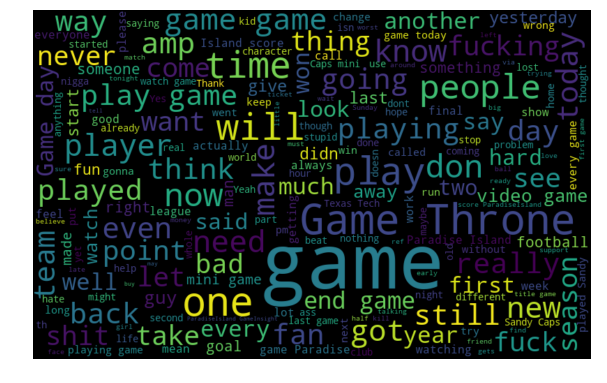

In [117]:
all_words = ' '.join([text for text in df['text'][df['sentiment']=='negative']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [118]:
def sent(df):
    if df=='negative':
        return 0
    elif df=='neutral':
        return 1
    else:
        return 2
df["sentiment"]=df["sentiment"].apply(sent)
df.head()

,sentiment,sname,text
0,2,pau ✨,Celebrate today win Next assignment will tough One game time #PaveTheWayDLSU
1,2,Map of the Soul: PERSONA,Anyways love the video game LOML Connor Kenway aka Ratonhnhak ton uwu
2,2,Roushan_Raj,#KnockKnockOnMakeMyTrip India Biggest Online Travel Show true game changer Play LIVE Upgrade the App amp Enrol Now
3,0,gabe,minecraft minecraft thats game minecraft minecraft that play
4,2,Johnny Drummond,When sponsored the league leaders they also inherited the leagues funniest fans Sorry come package lol Join the fun for our final home game next Saturday amp make some noise like these nutters


In [119]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['text'])
bow.shape

(10000, 1000)

In [120]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['text'])
tfidf.shape

(10000, 1000)

In [121]:
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow, df["sentiment"],random_state=42,test_size=0.3)
lreg = LogisticRegression()  
lreg.fit(xtrain_bow, ytrain)
filename="bow_lreg.sav"
pickle.dump(lreg, open(filename, 'wb'))

C:\Users\Ritesh Dutta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ritesh Dutta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [122]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_bow)
accuracy_score(yvalid,prediction) 

0.8463333333333334

In [123]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(tfidf, df["sentiment"],random_state=42,test_size=0.3)
lreg.fit(xtrain_tfidf, ytrain)
filename="tfidf_lreg.sav"
pickle.dump(lreg, open(filename, 'wb'))

In [124]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_tfidf)
accuracy_score(yvalid,prediction)

0.8033333333333333

In [125]:
xtrain_w2v, xvalid_w2v, ytrain, yvalid = train_test_split(wordvec_df, df["sentiment"],random_state=42,test_size=0.3)
lreg.fit(xtrain_w2v, ytrain)
filename="w2v_lreg.sav"
pickle.dump(lreg, open(filename, 'wb'))

C:\Users\Ritesh Dutta\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [126]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_w2v)
accuracy_score(yvalid,prediction)

0.7276666666666667

In [127]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)
filename="bow_svm.sav"
pickle.dump(svc, open(filename, 'wb'))

In [128]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_bow)
accuracy_score(yvalid, prediction)

0.8483333333333334

In [129]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)
filename="tfidf_svm.sav"
pickle.dump(svc, open(filename, 'wb'))

In [130]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_tfidf)
accuracy_score(yvalid, prediction)

0.8376666666666667

In [131]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)
filename = 'w2v_svm.sav'
pickle.dump(svc, open(filename, 'wb'))

In [132]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_w2v)
accuracy_score(yvalid, prediction)

0.7336666666666667

In [133]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)
filename="bow_rf"
pickle.dump(rf, open(filename, 'wb'))

In [134]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = loaded_model.predict(xvalid_bow)
accuracy_score(yvalid,prediction)

0.8403333333333334

In [135]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain) 
filename="w2v_rf"
pickle.dump(rf, open(filename, 'wb'))

In [136]:
loaded_model = pickle.load(open(filename, 'rb'))
prediction = rf.predict(xvalid_w2v)
accuracy_score(yvalid,prediction)

0.711

In [138]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v)
accuracy_score(yvalid, prediction)

0.742